# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from math import sqrt
#import wandb
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 07:10:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [          <=>       ] 201.24M  21.6MB/s    in 11s     

2023-10-15 07:10:39 (19.0 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge().fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
rmse_for_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE на тесте:{rmse_for_ridge}')

RMSE на тесте:9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
const_pred = np.full_like(y_test, np.mean(y_pred))
best_rmse_metric = np.sqrt(mean_squared_error(y_test, const_pred))
print(f'RMSE при среднем константном прогнозе:{best_rmse_metric}')

RMSE при среднем константном прогнозе:10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
X_train.shape

(463715, 90)

In [ ]:
y_train.size

463715

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled[:10000], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:10000], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled[:10000], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[:10000], dtype=torch.float32)

In [ ]:
model = nn.Sequential(
    nn.Linear(X_train_scaled.shape[1], 1)
)

In [ ]:
set_random_seed(805)
epochs = 10
learning_rate = 0.1

train_loss = []
test_loss = []

for epoch in range(epochs):
  train_pred = model(X_train_tensor)
  loss = torch.mean((y_train_tensor - torch.flatten(train_pred)) ** 2)
  train_loss.append(loss.item())
  loss.backward()

  with torch.no_grad():
    for p in model.parameters():
      p -= learning_rate * p.grad
      p.grad.zero_()

  with torch.no_grad():
    test_pred = model(X_test_tensor)
    test_mse = torch.mean((y_test_tensor - torch.flatten(test_pred)) ** 2).item()
    test_loss.append(test_mse)

  print(f'epoch: {epoch}', f'train loss: {loss.item()}', f'test rmse: {sqrt(test_mse)}', sep=' ', end='\n')

epoch: 0 train loss: 3995780.75 test rmse: 1599.9133570290612
epoch: 1 train loss: 2529993.0 test rmse: 1284.0690207305836
epoch: 2 train loss: 1619265.125 test rmse: 1033.559444347542
epoch: 3 train loss: 1041681.1875 test rmse: 834.6517237746532
epoch: 4 train loss: 673234.9375 test rmse: 673.6563942396747
epoch: 5 train loss: 437608.90625 test rmse: 549.1522728260351
epoch: 6 train loss: 286930.53125 test rmse: 445.92351502247556
epoch: 7 train loss: 190973.6875 test rmse: 372.8045734698007
epoch: 8 train loss: 130623.9375 test rmse: 309.7303766988314
epoch: 9 train loss: 93844.2578125 test rmse: 277.86060466536094


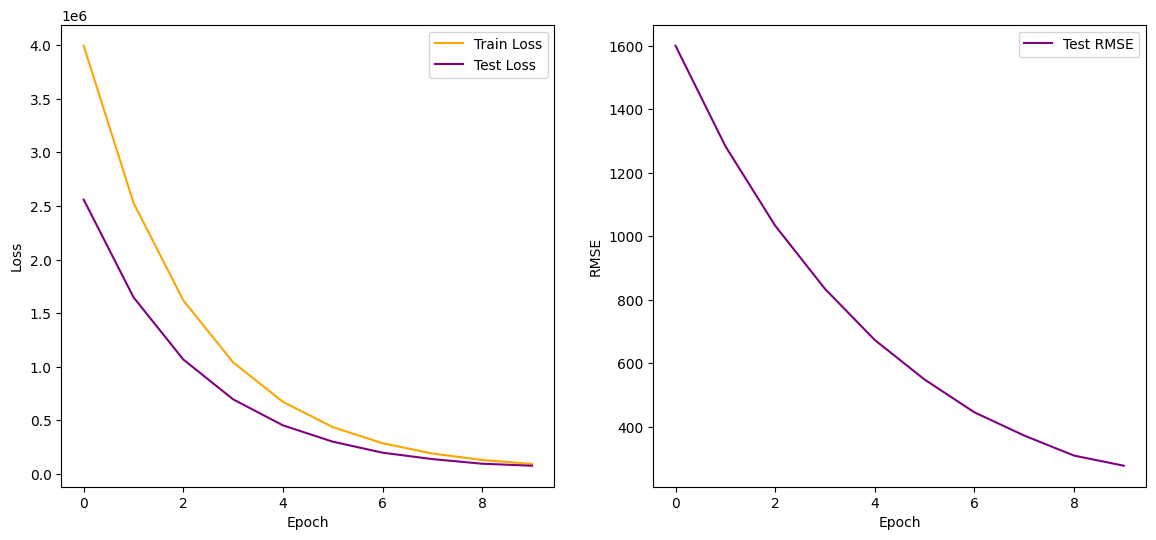

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(range(epochs), train_loss, label='Train Loss', color='orange')
plt.plot(range(epochs), test_loss, label='Test Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), np.sqrt(test_loss), color='purple', label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
X_train.shape

(463715, 90)

In [ ]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [ ]:
set_random_seed(42)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [ ]:
set_random_seed(42)
model = nn.Sequential(
    nn.Linear(90, 128),
    #nn.BatchNorm1d(128),
    nn.ReLU(),
   # nn.Dropout(0.1),
    nn.Linear(128, 64),
    #nn.BatchNorm1d(10),
    nn.ReLU(),
   # nn.Dropout(0.1),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.009)
criterion = nn.MSELoss()

In [ ]:
train_mse = []
test_rmse = []

In [ ]:
set_random_seed(142)
def train(model, optimizer, criterion, train_loader, test_loader=None, n_epochs = 5):

  for epoch in range(n_epochs):
    train_loss = []

    for x_train, y_train in tqdm(train_loader):
      y_pred = model(x_train.to(device))
      loss = criterion(y_pred.squeeze().to(device), y_train.to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      #print(loss.cpu().data.numpy())
      train_loss.append(loss.cpu().data.numpy())
      #break

    #break
    train_mse.append(train_loss)

    mse = np.mean(train_loss)
    print(f'epoch: {epoch + 1}, train mse: {mse}')

    if (test_loader != None):
      test(model, test_loader, epoch)




def test(model, test_loader, epoch=None):
  with torch.no_grad():
    predicts = []
    target = []

    for x_test, y_test in tqdm(test_loader):
      y_pred = model(x_test.to(device))
      y_pred = target_scaler.inverse_transform(y_pred.cpu().numpy())
      target.extend(y_test.numpy())
      #print(y_pred.flatten())
      predicts.extend(y_pred.flatten())
      #print(predicts)
      #print(target)
      #break

    rmse = sqrt(mean_squared_error(target, predicts))
    if epoch != None:
      test_rmse.append(rmse)
    print(f'test rmse: {rmse}')
    return predicts



In [ ]:
set_random_seed(142121)
model.to(device)
train(model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/1812 [00:00<?, ?it/s]

epoch: 1, train mse: 0.6703280806541443


  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.894518812436408


  0%|          | 0/1812 [00:00<?, ?it/s]

epoch: 2, train mse: 0.6423628330230713


  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.87335103794379


  0%|          | 0/1812 [00:00<?, ?it/s]

epoch: 3, train mse: 0.6323307156562805


  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.849966499566936


  0%|          | 0/1812 [00:00<?, ?it/s]

epoch: 4, train mse: 0.6239632368087769


  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.820594046519547


  0%|          | 0/1812 [00:00<?, ?it/s]

epoch: 5, train mse: 0.6162033081054688


  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.78185946158485


In [ ]:
set_random_seed(42)
assert len(test(model, test_loader)) == y_test.shape[0]

  0%|          | 0/202 [00:00<?, ?it/s]

test rmse: 8.78185946158485


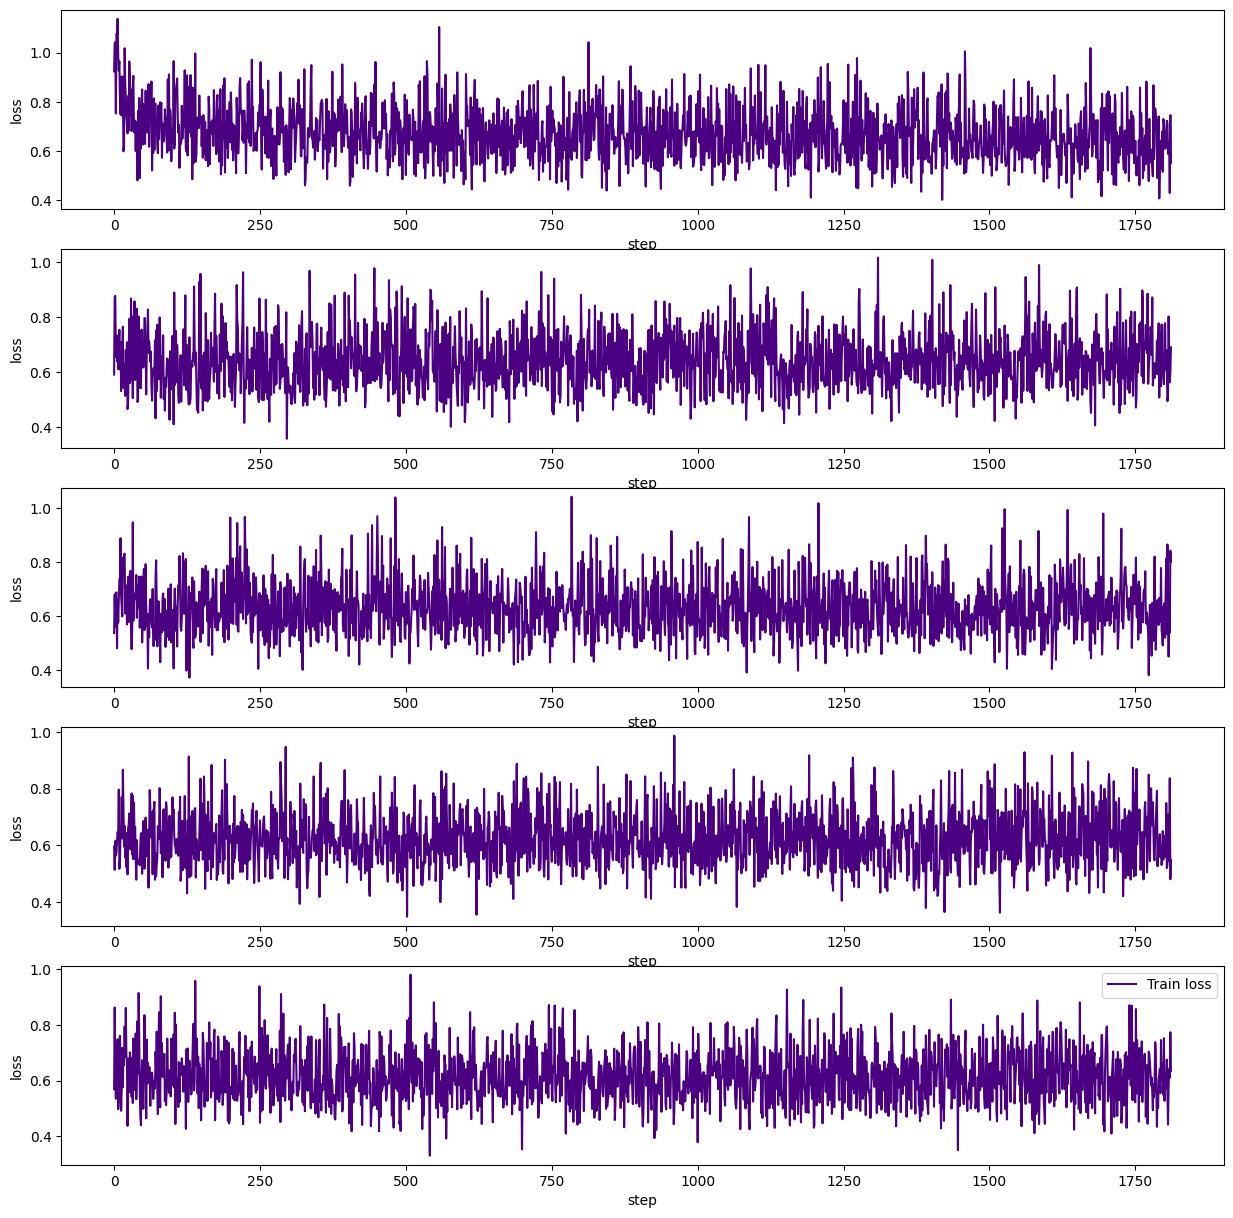

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
  plt.subplot(5, 1, i + 1)
  plt.plot(range(1812), train_mse[i], label = 'Train loss', color='indigo')
  plt.xlabel('step')
  plt.ylabel('loss')

#plt.title('Зависимость лосса от шага по эпохам')
plt.legend()
plt.show()

лосс принимает значения от 0 до 1, потому что на трейне я работала с нормализованным таргетом, решила оставить лосс тоже нормализованным

этот график мне кажется не особо понятным, нарисуем по эпохам...

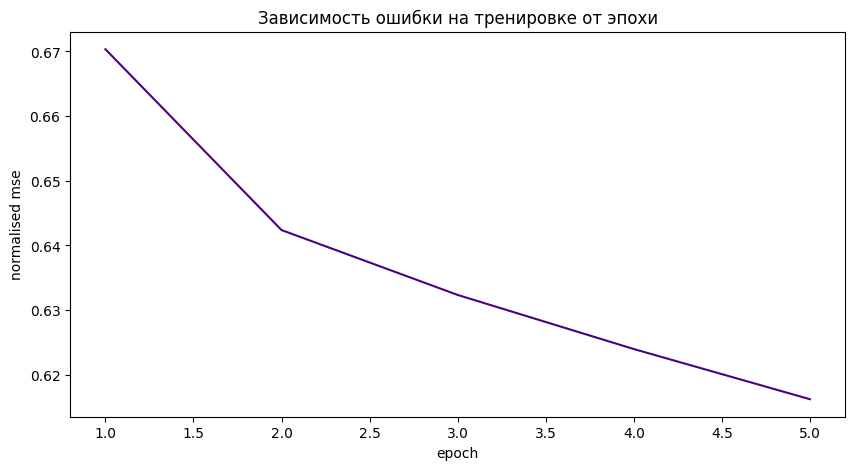

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 6), [np.mean(train_mse[i]) for i in range(5)], color = 'indigo')
plt.title('Зависимость ошибки на тренировке от эпохи')
plt.xlabel('epoch')
plt.ylabel('normalised mse')

plt.show()

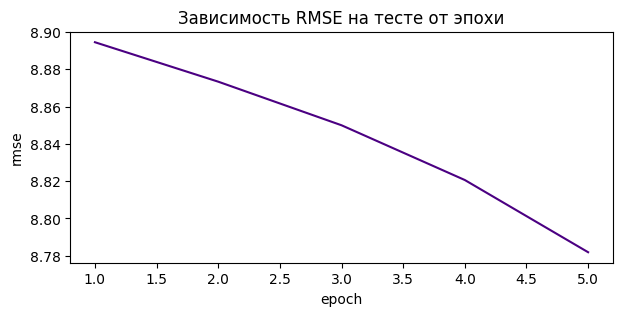

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(range(1, 6), test_rmse, color='indigo')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('Зависимость RMSE на тесте от эпохи')
plt.show()



## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**1 экперимент:**

  модель оставила как в задании 1(состоящую из 1 линейного слоя), оптимайзер - стохастический градиентный спуск с learning_rate = 0.01, ошибка - mse. нормализовала y_train, rmse на тесте стала 9.58(что гораздо лучше по сравнению с заданием 1, но плохо для задания 2)

**2 эксперимент:**

  усложнила архитектуру модели - теперь в ней три линейных слоя (90 - 30 - 10 - 1) с нелинейностями между ними. rmse на тесте получается в районе 8.85-8.90.

  решила уменьшить размер батчей для обучения с 64 до 32 - теперь rmse  8.80-8.85. пробовала прикрутить weight_decay и momentum, но не особо помогло.

**3 эксперимент:**

  решила в качестве оптимизатора взять Adam. при больших шагах метрика только ухудшается, при шаге 0.0005 хотя бы не становится хуже, чем была с градиентным спуском.

  еще раз сменила архитектуру, теперь линейные слои с нейронами 90 - 128 - 64 - 32 - 1. learning rate у оптимизатора 0.009. батчсайз увеличила до 256(у кого-то в чатике это сработало, решила попробовать). на пятой эпохе получилось выбить 8.79.

после этого эксперимента было еще много попыток выбить рмсе = 8.75, но ни добавление дропаута и батчнорма, ни изменение гиперпараметров не помогли, поэтому я оставила версию с наилучшим качеством из всех получившихся(хотя эта модель явно оставляет желать лучшего судя по тому, что мсе на тесте вообще не меняется...)

Ссылки на источники:


1.   https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
2.   все остальное взято с семинарских записей

